In [1]:
import sys
import import_ipynb
import networkx as nx
from antlr4 import *
from antlr4.InputStream import InputStream
import inspect
import matplotlib.pyplot as plt
import re

from JavaLexer import JavaLexer
from JavaParser import JavaParser
from JavaParserListener import JavaParserListener
from JavaParserVisitor import JavaParserVisitor


In [2]:
class CustomListener(JavaParserListener):
    def __init__(self):
        self.stack=[]
        self.identifier_table=[]
        self.graph=nx.MultiDiGraph()

    def isInsideContext(self, ctx, ancestor):
        # Traverse upwards in the parse tree to check if a for statement is an ancestor
        parent = ctx.parentCtx
        while parent is not None:
            if isinstance(parent, JavaParser.ForInitContext):
                return True
            parent = parent.parentCtx
        return False
        
    def enterMethodDeclaration(self, ctx:JavaParser.MethodDeclarationContext):
        # print("Enter method")
        for child in ctx.children:
            if isinstance(child, JavaParser.IdentifierContext):
                self.stack.append(child.getText())
                self.graph.add_node(child.getText())
                print(self.stack)

    # Exit a parse tree produced by JavaParser#methodDeclaration.
    # def exitMethodDeclaration(self, ctx:JavaParser.MethodDeclarationContext):
        # print("exit method declaration")


    # Enter a parse tree produced by JavaParser#methodBody.
    # def enterMethodBody(self, ctx:JavaParser.MethodBodyContext):
        # print("enter method body")
    
    # Exit a parse tree produced by JavaParser#methodBody.
    # def exitMethodBody(self, ctx:JavaParser.MethodBodyContext):
        # print("exit method body")

    # ## Statement is a child of blockStatement
    
     # Enter a parse tree produced by JavaParser#blockStatement.
    def enterStatement(self, ctx:JavaParser.BlockStatementContext):
        # print("Entering statement")
        for child in ctx.children :
            if child.getText() in ["for","if","else","while","switch","try","catch"]:
                self.graph.add_edge(self.stack[-1],child.getText(),relation="contains")
                self.stack.append(child.getText())
                print(self.stack)
 
    # Exit a parse tree produced by JavaParser#blockStatement.
    # def exitStatement(self, ctx:JavaParser.BlockStatementContext):
        # print("Exiting statement")

    def enterBlock(self, ctx:JavaParser.BlockContext):
        print(self.stack[-1],"block entered")  

    def enterForControl(self, ctx:JavaParser.ForControlContext):
        self.graph.add_edge(self.stack[-1],ctx.children[2].getText(),relation='condition')

    def enterExpression(self, ctx:JavaParser.ExpressionContext):
        if hasattr(ctx,'bop') and ctx.bop!=None:
            print("The bop of this expression is ",ctx.bop.text, ctx.getText())
            print(f"Expression index: {ctx.getRuleIndex()}")
        # if hasattr(ctx,'bop') and self.isInsideContext(ctx,JavaParser.BlockContext):
        #     print("INSIDE BLOCK CONTEXT",ctx.getText())
        #     self.graph.add_edge(self.stack[-1], ctx.getText(),relation='contains')
            
    def enterParExpression(self, ctx:JavaParser.ParExpressionContext):
        if ctx.parentCtx.children[0].getText()in ['if','while']:
            if(self.stack[-1]=='else'):
                self.graph.add_edge(self.stack[-2],ctx.getText(),relation='condition')
            else:
                self.graph.add_edge(self.stack[-1],ctx.getText(),relation='condition')
    
    # Exit a parse tree produced by JavaParser#block.
    def exitBlock(self, ctx:JavaParser.BlockContext):
        print(self.stack.pop(),"block exited")

    def enterForInit(self, ctx:JavaParser.ForInitContext):
        # print("THIS IS FOR INIT",ctx.getText())
        for child in ctx.children:
            print(child.getText())

    def enterIdentifier(self, ctx:JavaParser.IdentifierContext):
        if self.isInsideContext(ctx,JavaParser.ForInitContext):
            self.graph.add_edge(self.stack[-1],ctx.getText(),relation='contains')
            
        flag=False
        j=0
        print(ctx.parentCtx.getText())
        if not isinstance(ctx.parentCtx,JavaParser.ClassDeclarationContext) and not isinstance(ctx.parentCtx,JavaParser.MethodDeclarationContext):
            print("IF ENTERED")
            for i in self.identifier_table:
                if ctx.getText() == i[:len(ctx.getText())]:
                    flag=True
                    break
                j+=1
                    
            if flag==False:
                self.identifier_table.append(ctx.getText())
                print(self.stack)
                self.graph.add_edge(self.stack[-1],ctx.getText(),relation='contains')

            else:
                self.graph.add_edge(self.stack[-1],self.identifier_table[j],relation='contains')

    def enterLocalVariableDeclaration(self, ctx:JavaParser.LocalVariableDeclarationContext):
        # get the variable type
        var_type=ctx.children[0].getText()
        
        # list containing the list of variable declarator instances
        declarator_list=[]

        # list containing the list of all variables with identifier and value if present
        var_list=[]
        
        # append the child to declarator_list if it is a varibale declarator instance
        for child in ctx.children[1].children:
            if isinstance(child,JavaParser.VariableDeclaratorContext):
                declarator_list.append(child)
                
        for dec in declarator_list:
            # append the initial value of the variable if present else ignore.
            # attach the string with the var type 
            if isinstance(dec.children[-1],JavaParser.VariableInitializerContext):
                var_list.append(dec.children[0].getText()+'_'+var_type+':'+dec.children[-1].getText())
            else:
                var_list.append(var_type+'_'+dec.children[0])
        print('INSIDE DECLARATION',var_list,self.stack)
        for var in var_list:
            self.graph.add_edge(self.stack[-1],var,relation='contains')
            self.identifier_table.append(var)
            
    def enterFormalParameter(self, ctx:JavaParser.FormalParameterContext):
        var_type=ctx.children[0].getText()
        var_name=ctx.children[-1].getText()
        self.graph.add_edge(self.stack[-1],var_name+'_'+var_type,relation='parameter')
        self.identifier_table.append(var_name+'_'+var_type)

(compilationUnit (typeDeclaration (classOrInterfaceModifier public) (classDeclaration class (identifier Main) (classBody { (classBodyDeclaration (modifier (classOrInterfaceModifier static)) (memberDeclaration (methodDeclaration (typeTypeOrVoid void) (identifier myMethod) (formalParameters ( (formalParameterList (formalParameter (typeType (primitiveType int)) (variableDeclaratorId (identifier a))) , (formalParameter (typeType (primitiveType int)) (variableDeclaratorId (identifier b))) , (formalParameter (typeType (primitiveType int)) (variableDeclaratorId (identifier c)))) )) (methodBody (block { (blockStatement (localVariableDeclaration (typeType (primitiveType int)) (variableDeclarators (variableDeclarator (variableDeclaratorId (identifier declaration_a)) = (variableInitializer (expression (primary (literal (integerLiteral 0)))))) , (variableDeclarator (variableDeclaratorId (identifier declaration_b)) = (variableInitializer (expression (primary (literal (integerLiteral 1)))))))) ;) (b

TypeError: draw_networkx_edge_labels() missing 1 required positional argument: 'pos'

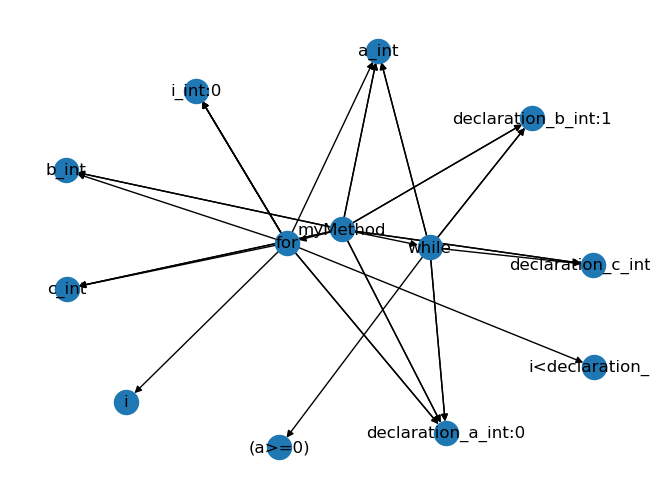

In [6]:
class JavaParseGraph(JavaParserVisitor):
    def __init__(self,location):
        self.location=location
    def parse_tree_generator(self):
        input_code=FileStream(self.location)
        #input_stream=InputStream(input_code)
        lexer=JavaLexer(input_code)
        stream=CommonTokenStream(lexer)
        parser=JavaParser(stream)
        tree=parser.compilationUnit()
        print(tree.toStringTree(recog=parser))
        # visitor=CustomVisitor(self.location)
        # visitor.visit(tree)
        walker=ParseTreeWalker()
        customWalker=CustomListener()   
        walker.walk(customWalker,tree)
        # print(parser.LBRACE)
        print(customWalker.stack, list(customWalker.graph.edges(data=True)))
        print(customWalker.identifier_table)
        nx.draw(customWalker.graph,with_labels=True)
        edge_labels = nx.get_edge_attributes(customWalker.graph, 'relation')
        nx.draw_networkx_edge_labels(customWalker.graph,  edge_labels=edge_labels)
        plt.show()
        show_graph_pyvis(customWalker.graph)
javaParse=JavaParseGraph("./OneMethodOnly.java")
javaParse.parse_tree_generator()

In [4]:
# My show files
import networkx as nx
import pyvis
import os
import matplotlib.pyplot as plt
import errno
import math

# number_connected_components, largest_connected_component, top_PR, #node#, #relns,

# basePath = os.path.dirname(os.path.realpath(__file__)).replace('\\', '/')
# base_path = basePath.replace("Cre8Blend", "data/", 1)
# htmlBranch = basePath + "/FDG/"

# print("FDG files to: ", htmlBranch)

#test_graph = nx.complete_graph(5)
#test_graph.graph['Graphid'] = "test graph"

def show_graph(this_graph):
    z = this_graph.graph['Graphid']
    plt.figure(z)   # sourceGraph.graph['Graphid'])
    #pos_nodes = nx.spring_layout(TgtGraph, k=0.2, pos=None, fixed=None, iterations=150,
    #                             threshold=0.01, weight='weight', scale=2, center=None, dim=2, seed=None)
    # pos_nodes = nx.draw_kamada_kawai()
    pos_nodes = nx.circular_layout(this_graph)
    colors = []
    for u, data in this_graph.nodes(data=True):
        if data !={} and "|" in u:
            z = u.split("|")
            if len(z) >=1 and z[0] == z[1]:
                colors.append("green")
            else:
                colors.append("orange")
        else:
            colors.append("red")
    nx.draw(this_graph, pos_nodes, node_color=colors, with_labels=False)
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.05)
    node_attrs = nx.get_node_attributes(this_graph, 'label')
    custom_node_attrs = {}
    for node, attr in node_attrs.items():
        custom_node_attrs[node] = attr
    edge_labels1 = dict([((u, v,), d['label'])
                         for u, v, d in this_graph.edges(data=True) if d!= {}])
    nx.draw_networkx_edge_labels(this_graph, pos_attrs, alpha=0.7, edge_labels=edge_labels1)
    nx.draw_networkx_labels(this_graph, pos_attrs, labels=custom_node_attrs)
    plt.title(this_graph.graph['Graphid'])  #("abc")
    plt.axis('off')
    #time.sleep(0.5)
    plt.show()
#show_graph(test_graph)

def show_graph_pyvis(networkx_graph, notebook=True, output_filename='graph.html', show_buttons=True,
                only_physics_buttons=True): # aka draw_graph3()
    if networkx_graph.number_of_nodes() == 0:
        return
    """    from quadrismegistus/pyvis_for_networkx.py
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?    """
    from pyvis import network as py_net
    graphName = networkx_graph.graph['Graphid']
    output_filename = htmlBranch + graphName + " Z.html" # htmlBranch + graphName + '.json',
    # pyvis_graph = py_net.Network(directed=True, height='90%', width='90%', notebook=notebook)
    pyvis_graph = py_net.Network(directed=True, height='1200px', width='100%', notebook=notebook,  cdn_resources='local')
    options = """
    var options = {
        "nodes": {
            "shape": "dot",
            "size": 10
        },
        "edges": {
             "color": {
                 "inherit": true
             },
             "smooth": true
         },
        "physics": {
             "forceAtlas2Based": {
                 "springLength": 120
             },
             "minVelocity": 0.75,
             "solver": "forceAtlas2Based"
         }
     }
     """
    pyvis_graph.show_buttons(['nodes', 'edges', 'physics'])
    #pyvis_graph.set_options(options)
    if False and show_buttons:
        if only_physics_buttons:
            #pyvis_graph.show_buttons(filter_=['interaction', 'layout', 'manipulation', 'selection', 'renderer'])
            pyvis_graph.show_buttons(['nodes', 'edges', 'physics'])
        #else:
        #    pyvis_graph.show_buttons()
    # return and also save
    #pyvis_graph.set_edge_smooth('dynamic')
    #pyvis_graph.forceAtlas2Based()
    # for each node and its attributes in the networkx graph
    for node, node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(str(node), **node_attrs, size=10, borderWidth=1, # color='pink',
                             labelHighlightBold=True, border='red', edgecolor='lightblue')
    # for each edge and its attributes in the networkx graph
    for source, target, edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value'] = edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(str(source), str(target), color= "lightblue", **edge_attrs)
    #pyvis_graph.set_options(options)
    if not os.path.exists(os.path.dirname(output_filename)):
        try:
            os.makedirs(os.path.dirname(output_filename))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    pyvis_graph.show(output_filename)  # interaction navigationButtons:
    return
#show_graph_pyvis(test_graph)


def show_graph_pyvis_big_nodes(networkx_graph, notebook=True, output_filename='graph.html', show_buttons=True,
                only_physics_buttons=True): # aka draw_graph3()
    if networkx_graph.number_of_nodes() == 0:
        return
    """    from quadrismegistus/pyvis_for_networkx.py
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?    """
    from pyvis import network as py_net
    graphName = networkx_graph.graph['Graphid']
    output_filename = htmlBranch + graphName + " Z.html" # htmlBranch + graphName + '.json',
    # print("FDG in directory: ", htmlBranch + graphName + " Z.html")
    # pyvis_graph = py_net.Network(directed=True, height='90%', width='90%', notebook=notebook)
    pyvis_graph = py_net.Network(directed=True, height='1200px', width='100%', notebook=notebook, cdn_resources='local')
    options = """
    var options = {
        "nodes": {
            "shape": "dot",
            "size": 10
        },
        "edges": {
             "color": {
                 "inherit": true
             },
             "smooth": true
         },
        "physics": {
             "forceAtlas2Based": {
                 "springLength": 120
             },
             "minVelocity": 0.75,
             "solver": "forceAtlas2Based"
         }
     }
     """
    pyvis_graph.show_buttons(['nodes', 'edges', 'physics'])
    #pyvis_graph.set_options(options)
    if False and show_buttons:
        if only_physics_buttons:
            #pyvis_graph.show_buttons(filter_=['interaction', 'layout', 'manipulation', 'selection', 'renderer'])
            pyvis_graph.show_buttons(['nodes', 'edges', 'physics'])
        #else:
        #    pyvis_graph.show_buttons()
    # return and also save
    #pyvis_graph.set_edge_smooth('dynamic')
    #pyvis_graph.forceAtlas2Based()
    # for each node and its attributes in the networkx graph
    for node, node_attrs in networkx_graph.nodes(data=True):
        z = round(3 * math.log(networkx_graph.degree(node)))
        pyvis_graph.add_node(str(node), **node_attrs, size=5+z, borderWidth=1, # color='pink',
                             labelHighlightBold=True, border='red', edgecolor='lightblue')
    # for each edge and its attributes in the networkx graph
    for source, target, edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value'] = edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(str(source), str(target), color= "lightblue", **edge_attrs)
    #pyvis_graph.set_options(options)
    if not os.path.exists(os.path.dirname(output_filename)):
        try:
            os.makedirs(os.path.dirname(output_filename))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    pyvis_graph.show(output_filename)  # interaction navigationButtons:
    return
# show_graph_pyvis(test_graph)


def show_blended_space(mapped_preds, red_preds, green_preds, output_filename="example"):
    """Display a FDG from 3 lists of predicates. Counterparts, red predicates and green predicates. Accepts 3
    lists of sub-lists. """
    notebook=True
    show_buttons=True
    only_physics_buttons=True
    """    from quadrismegistus/pyvis_for_networkx.py
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?    """
    from pyvis import network as py_net
    output_filename = htmlBranch + output_filename + ".html"
    pyvis_graph = py_net.Network(directed=True, height='1200px', width='100%', notebook=notebook, cdn_resources='local')
    options = """
    var options = {
        "nodes": {
            "shape": "dot",
            "size": 10
        },
        "edges": {
             "color": {
                 "inherit": true
             },
             "smooth": true
         },
        "physics": {
             "forceAtlas2Based": {
                 "springLength": 120
             },
             "minVelocity": 0.75,
             "solver": "forceAtlas2Based"
         }
     } """
    pyvis_graph.show_buttons(['physics'])
    if True and show_buttons:
        if False and only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['interaction', 'layout', 'manipulation', 'selection', 'renderer'])
            pyvis_graph.show_buttons(['nodes', 'edges', 'physics'])
        else:
            pyvis_graph.show_buttons(filter_=['physics'])
    #pyvis_graph.set_edge_smooth('dynamic')
    # pyvis_graph.forceAtlas2Based()
    previous_nodes = []
    for x,r,y in mapped_preds:
        pyvis_graph.add_node(str(x), size=10, borderWidth=1, # color='pink',
                             labelHighlightBold=True, border='blue', edgecolor='lightblue')
        pyvis_graph.add_node(str(y), size=10, borderWidth=1, # color='pink',
                             labelHighlightBold=True, border='blue', edgecolor='lightblue')
        previous_nodes.append(x)
        previous_nodes.append(y)
        if r != 'None-None' and r != None:
            pyvis_graph.add_edge(str(x), str(y), color= "lightblue", **{'label': str(r)})
        else:
            pyvis_graph.add_edge(str(x), str(y), color="lightblue")
    for x,r,y in red_preds:
        if not x in previous_nodes:
            pyvis_graph.add_node(str(x), size=10, borderWidth=1, color='pink',
                             labelHighlightBold=True, border='pink', edgecolor='red')
            previous_nodes.append(x)
        if not y in previous_nodes:
            pyvis_graph.add_node(str(y), size=10, borderWidth=1, color='pink',
                             labelHighlightBold=True, border='red', edgecolor='red')
            previous_nodes.append(y)
        if r != 'None-None' and r != None:
            pyvis_graph.add_edge(str(x), str(y), color= "pink", **{'label': str(r)})
        else:
            pyvis_graph.add_edge(str(x), str(y), color="pink")
    for x,r,y in green_preds:
        if not x in previous_nodes:
            pyvis_graph.add_node(str(x), size=10, borderWidth=1, color='lightgreen',
                             labelHighlightBold=True, border='green', edgecolor='green')
            previous_nodes.append(x)
        if not y in previous_nodes:
            pyvis_graph.add_node(str(y), size=10, borderWidth=1, color='lightgreen',
                             labelHighlightBold=True, border='green', edgecolor='green')
            previous_nodes.append(y)
        if r != 'None-None' and r != None:
            pyvis_graph.add_edge(str(x), str(y), color= "lightgreen", **{'label': str(r)})
        else:
            pyvis_graph.add_edge(str(x), str(y), color="lightgreen")
    if not os.path.exists(os.path.dirname(output_filename)):
        try:
            os.makedirs(os.path.dirname(output_filename))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    pyvis_graph.show(output_filename)  # interaction navigationButtons:
    return



def show_blended_space_big_nodes(graph1, mapped_preds, red_preds, green_preds, output_filename="example"):
    """Display a FDG from 3 lists of predicates. Counterparts, red predicates and green predicates. Accepts 3
    lists of sub-lists. """
    notebook=True
    show_buttons=True
    only_physics_buttons=True
    """    from quadrismegistus/pyvis_for_networkx.py
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?    """
    from pyvis import network as py_net
    output_filename = htmlBranch + output_filename + ".html"
    pyvis_graph = py_net.Network(directed=True, height='1200px', width='100%', notebook=notebook, cdn_resources='local')
    # pyvis_graph = py_net.Network(directed=True, height='100%', width='100%', notebook=notebook, cdn_resources='local')  # ["local", "in_line", "remote"]
    options = """
    var options = {
        "nodes": {
            "shape": "dot",
            "size": 10
        },
        "edges": {
             "color": {
                 "inherit": true
             },
             "smooth": true
         },
        "physics": {
             "forceAtlas2Based": {
                 "springLength": 120
             },
             "minVelocity": 0.75,
             "solver": "forceAtlas2Based"
         }
     }
     """
    #pyvis_graph.set_options(options)
    # pyvis_graph.show_buttons(['physics'])  # (['nodes', 'edges', 'physics'])
    pyvis_graph.show_buttons(['nodes', 'edges', 'physics'])
    if True and show_buttons:
        if False and only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['interaction', 'layout', 'manipulation', 'selection', 'renderer'])
            # pyvis_graph.show_buttons(['nodes', 'edges', 'physics'])
        else:
            pyvis_graph.show_buttons(filter_=['physics'])
    # return and also save
    #pyvis_graph.set_edge_smooth('dynamic')
    #pyvis_graph.forceAtlas2Based()
    previous_nodes = []
    for x,r,y in mapped_preds:
        #x = simplify_node(x)  # for OPEN DAY 2022
        #y = simplify_node(y)
        siz1 = graph1.degree(x)
        siz2 = graph1.degree(y)
        if not isinstance(siz1, int):
            siz1 = 0
        if not isinstance(siz2, int):
            siz2 = 0
        pyvis_graph.add_node(str(x), size=5+siz1, borderWidth=1, # color='pink',
                             labelHighlightBold=True, border='blue', edgecolor='lightblue')
        pyvis_graph.add_node(str(y), size=5+siz2, borderWidth=1, # color='pink',
                             labelHighlightBold=True, border='blue', edgecolor='lightblue')
        previous_nodes.append(x)
        previous_nodes.append(y)
        if r != 'None-None' and r != None:
            pyvis_graph.add_edge(str(x), str(y), color= "lightblue", **{'label': str(r)})
        else:
            pyvis_graph.add_edge(str(x), str(y), color="lightblue")
    for x,r,y in red_preds:
        #x = simplify_node(x)  # for OPEN DAY 2022
        #y = simplify_node(y)
        siz1 = graph1.degree(x)
        siz2 = graph1.degree(y)
        if not isinstance(siz1, int):
            siz1 = 0
        if not isinstance(siz2, int):
            siz2 = 0
        if not x in previous_nodes:
            pyvis_graph.add_node(str(x), size=5+siz1, borderWidth=1, color='pink',
                             labelHighlightBold=True, border='pink', edgecolor='red')
            previous_nodes.append(x)
        if not y in previous_nodes:
            pyvis_graph.add_node(str(y), size=5+siz2, borderWidth=1, color='pink',
                             labelHighlightBold=True, border='red', edgecolor='red')
            previous_nodes.append(y)
        if r != 'None-None' and r != None:
            pyvis_graph.add_edge(str(x), str(y), color= "pink", **{'label': str(r)})
        else:
            pyvis_graph.add_edge(str(x), str(y), color="pink")
    for x,r,y in green_preds:
        if not x in previous_nodes:
            pyvis_graph.add_node(str(x), size=10, borderWidth=1, color='lightgreen',
                             labelHighlightBold=True, border='green', edgecolor='green')
            previous_nodes.append(x)
        if not y in previous_nodes:
            pyvis_graph.add_node(str(y), size=10, borderWidth=1, color='lightgreen',
                             labelHighlightBold=True, border='green', edgecolor='green')
            previous_nodes.append(y)
        if r != 'None-None' and r != None:
            pyvis_graph.add_edge(str(x), str(y), color= "lightgreen", **{'label': str(r)})
        else:
            pyvis_graph.add_edge(str(x), str(y), color="lightgreen")
    if not os.path.exists(os.path.dirname(output_filename)):
        try:
            os.makedirs(os.path.dirname(output_filename))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise   # pyvis_graph.show_buttons(filter_=['physics'])  # pyvis_graph.show_buttons()
    pyvis_graph.show(output_filename)  # interaction navigationButtons:
    return
# show_blended_space([["a","rel","b"], [1,2,3]], [["a","rel","c"], [1,2,7]], [["a", "to", 17]])
# show_blended_space([['rays|rays', 'reach | to', 'tumor|tissue'], ['rays|rays', 'pass_on | on', 'way|way'], ['tumor|tissue', '**in', 'stomach'], ['tumor|tissue', '**destroyed', 'patient|patient'], ['tumor|tissue', '**at', 'intensity'], ['tumor|tissue', '**with', 'rays|tumor'], ['There|time', 'destroy | destroying', 'tumor|tissue'], ['There|time', '**used', 'tumor|tissue'], ['There|time', '**is', 'kind|kind'], ['rays|tumor', 'are | at', 'tissue|intensity'], ['rays|tumor', '**to', 'tissue|intensity'], ['rays|tumor', '**at', 'time'], ['way|way', '**to', 'tumor|tissue'], ['It|It', 'operate_on | operate_on', 'patient|patient'], ['It|It', '**is', 'patient|patient'], ['patient|patient', '**has', 'tumor|tissue'], ['kind|kind', 'of | of', 'ray|ray'], ['you', '**are', 'doctor'], ['doctor', '**faced_with', 'patient|patient'], ['time', '**avoid', 'tissue|intensity'], ['time', '**destroying', 'tissue|intensity'], ['they', '**affect', 'tumor|tissue']],[["a","rel","c"], [1,2,7]], [["stomach", "to", 17]])


def simplify_node(nod):
    a_short = list(set(nod.split("_")))[:3]
    a_new = "_".join(a_short)
    return a_new


def show_pyvis_old(targetGraph):
    #global all_csv_files
    #targetGraph = build_graph_from_csv(all_csv_files[0])
    from pyvis.network import Network
    net = Network(notebook=False)
    net.from_nx(targetGraph)
    net.show("example.html")
    input("Press Enter to continue...")
#show_pyvis_old(nx.complete_graph(5))


def show_pyvis2(targetGraph):
    #global all_csv_files
    #targetGraph = build_graph_from_csv(all_csv_files[0])
    from pyvis.network import Network
    net = Network(notebook=True)
    net.from_nx(targetGraph)
    net.show("example.html")
    input("Press Enter to continue...")


def show_random_graph():
    temp_graph = nx.random_partition_graph([7,7,7],0.95, 0.05)
    temp_graph.graph['Graphid'] = "random_partition_graph([15,15,15],0.95, 0.05)"
    show_graph_pyvis(temp_graph, notebook=True)
    show_graph_pyvis(temp_graph)
    # show_pyvis_old(temp_graph)  doesnt work
    # show_pyvis2(temp_graph)     doesnt work
# show_random_graph()


def show_circular_graph(G):
    """ Accepts a straight NetworkX graph and displays it in a circular layout. """
    node_color = [G.degree(v) for v in G]
    node_size = [0.0005 * nx.get_node_attributes(G, 'population')[v] for v in G]
    edge_width = [0.0015 * G[u][v]['weight'] for u, v in G.edges()]
    plt.figure(figsize=(10, 9))
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos, node_size=node_size, node_color=node_color, alpha=0.7,
                 with_labels=True, width=edge_width, edge_color='.4', cmap=plt.cm.Blues)


# print("loaded ShowGraphs.py", end=" ")

#show_blended_space([["a","rel","b"], [1,2,3]], [["a","rel","c"], [1,2,7]], [["a", "to", 17]])
""" show_blended_space([['rays|rays', 'reach | to', 'tumor|tissue'], ['rays|rays', 'pass_on | on', 'way|way'],
                    ['tumor|tissue', '**in', 'stomach'], ['tumor|tissue', '**destroyed', 'patient|patient'],
                    ['tumor|tissue', '**at', 'intensity'], ['tumor|tissue', '**with', 'rays|tumor'],
                    ['There|time', 'destroy | destroying', 'tumor|tissue'], ['There|time', '**used', 'tumor|tissue'],
                    ['There|time', '**is', 'kind|kind'], ['rays|tumor', 'are | at', 'tissue|intensity'],
                    ['rays|tumor', '**to', 'tissue|intensity'], ['rays|tumor', '**at', 'time'], ['way|way', '**to', 'tumor|tissue'],
                    ['It|It', 'operate_on | operate_on', 'patient|patient'], ['It|It', '**is', 'patient|patient'],
                    ['patient|patient', '**has', 'tumor|tissue'], ['kind|kind', 'of | of', 'ray|ray'], ['you', '**are', 'doctor'],
                    ['doctor', '**faced_with', 'patient|patient'], ['time', '**avoid', 'tissue|intensity'],
                    ['time', '**destroying', 'tissue|intensity'], ['they', '**affect', 'tumor|tissue']],
                   [["a","rel","c"], [1,2,7]], [["stomach", "to", 17]])
"""
#show_blended_space_big_nodes()
#stop()
#show_blended_space([["a","rel","b"], [1,2,3]], [["a","rel","c"], [1,2,7]], [["a", "to", 17]])
""" 
show_blended_space([['a small country', 'called', 'Zerdia'],
['a small country called Zerdia', 'learned', 'to make the world ’s smartest computer'],
['that', 'make', 'the world ’s smartest computer'],
['the missiles', 'were', 'badly aimed'],
['The Zerdian government', 'realized', 'that Gagrach wanted Zerdian computers so it offered to sell some of its computers to the country'],
['Gagrach', 'wanted', 'Zerdian computers'],
['it', 'offered', 'to sell some of its computers to the country'],
['it', 'sell', 'some of its computers'], ['it', 'sell', 'to the country'],
['The government of Gagrach', 'was', 'very pleased'],
['It', 'promised', 'never to attack Zerdia again'],
['It', 'attack never', 'Zerdia']], [], [], output_filename="Zerdia -small")

show_blended_space([['a small country', 'called', 'Zerdia'],
['a small country', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['Zerdia', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['Zerdia', 'WITHIN', 'The Zerdian government'],
['a small country called Zerdia', 'learned', 'to make the world ’s smartest computer'],
['a small country called Zerdia', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['to make the world ’s smartest computer', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['that', 'make', 'the world ’s smartest computer'],
['the world ’s smartest computer', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['the missiles', 'were', 'badly aimed'],
['The Zerdian government', 'realized', 'that Gagrach wanted Zerdian computers so it offered to sell some of its computers to the country'],
['Gagrach', 'wanted', 'Zerdian computers'],
['Gagrach', 'WITHIN', 'its warlike neighbor Gagrach'],
['Gagrach', 'WITHIN', 'The government of Gagrach'],
['it', 'offered', 'to sell some of its computers to the country'],
['it', 'sell', 'some of its computers'], ['it', 'sell', 'to the country'],
['The government of Gagrach', 'was', 'very pleased'],
['It', 'promised', 'never to attack Zerdia again'],
['It', 'attack never', 'Zerdia'],
['Zerdia', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['Zerdia', 'WITHIN', 'The Zerdian government']], [], [], output_filename="Zerdia -BIG")


show_blended_space([['a small country', 'called', 'Zerdia'],
['a small country called Zerdia', 'learned', 'to make the world ’s smartest computer'],
['a small country called Zerdia', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['to make the world ’s smartest computer', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['that', 'make', 'the world ’s smartest computer'], ['the missiles', 'were', 'badly aimed'],
['the world ’s smartest computer', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['The Zerdian government', 'realized', 'that Gagrach wanted Zerdian computers so it offered to sell some of its computers to the country'],
['Gagrach', 'wanted', 'Zerdian computers'], ['it', 'offered', 'to sell some of its computers to the country'],
['it', 'sell', 'some of its computers'], ['it', 'sell', 'to the country'],
['The government of Gagrach', 'was', 'very pleased'],
['It', 'promised', 'never to attack Zerdia again'],
['It', 'attack never', 'Zerdia']], [], [],  output_filename="Karla - small")

show_blended_space([['a small country', 'called', 'Zerdia'],
['a small country', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['Zerdia', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['Zerdia', 'WITHIN', 'The Zerdian government'],
['a small country called Zerdia', 'learned', 'to make the world ’s smartest computer'],
['a small country called Zerdia', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['to make the world ’s smartest computer', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['that', 'make', 'the world ’s smartest computer'], ['the missiles', 'were', 'badly aimed'],
['the world ’s smartest computer', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['The Zerdian government', 'realized', 'that Gagrach wanted Zerdian computers so it offered to sell some of its computers to the country'],
['Gagrach', 'wanted', 'Zerdian computers'], ['Gagrach', 'WITHIN', 'its warlike neighbor Gagrach'], ['Gagrach', 'WITHIN', 'The government of Gagrach'],
['it', 'offered', 'to sell some of its computers to the country'], ['it', 'sell', 'some of its computers'], ['it', 'sell', 'to the country'],
['The government of Gagrach', 'was', 'very pleased'], ['It', 'promised', 'never to attack Zerdia again'], ['It', 'attack never', 'Zerdia'],
['Zerdia', 'WITHIN', 'a small country called Zerdia that learned to make the world ’s smartest computer'],
['Zerdia', 'WITHIN', 'The Zerdian government']], [], [],  output_filename="Karla - BIG")

"""


' \nshow_blended_space([[\'a small country\', \'called\', \'Zerdia\'],\n[\'a small country called Zerdia\', \'learned\', \'to make the world ’s smartest computer\'],\n[\'that\', \'make\', \'the world ’s smartest computer\'],\n[\'the missiles\', \'were\', \'badly aimed\'],\n[\'The Zerdian government\', \'realized\', \'that Gagrach wanted Zerdian computers so it offered to sell some of its computers to the country\'],\n[\'Gagrach\', \'wanted\', \'Zerdian computers\'],\n[\'it\', \'offered\', \'to sell some of its computers to the country\'],\n[\'it\', \'sell\', \'some of its computers\'], [\'it\', \'sell\', \'to the country\'],\n[\'The government of Gagrach\', \'was\', \'very pleased\'],\n[\'It\', \'promised\', \'never to attack Zerdia again\'],\n[\'It\', \'attack never\', \'Zerdia\']], [], [], output_filename="Zerdia -small")\n\nshow_blended_space([[\'a small country\', \'called\', \'Zerdia\'],\n[\'a small country\', \'WITHIN\', \'a small country called Zerdia that learned to make the wo